![Redfin Logo](https://upload.wikimedia.org/wikipedia/commons/thumb/5/53/Redfin_logo.png/180px-Redfin_logo.png)
# Exploratory Data Analysis
This notebook will be used to perform exploratory data analysis on the Redfin dataset that was transformed and loaded into the Snowflake database.  
Includes data on all residential properties in the United States that were listed and sold from 2017 and onwards.

In [418]:
import duckdb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib_inline
from matplotlib.ticker import FuncFormatter

pd.options.mode.copy_on_write = True
pd.options.display.float_format = '{:.4f}'.format
matplotlib_inline.backend_inline.set_matplotlib_formats('png')

Connecting to Snowflake DB using IDE database tool.  

**Selecting 4-week data for metro regions.**

In [22]:
%%sql
-- save to dataframe
-- selecting 4 week data for metro regions
select f.*, d.region, d.state from HOUSING_MARKET_DW.ANALYTICS.F_HOUSING_MARKET f full join HOUSING_MARKET_DW.ANALYTICS.DIM_REGION d on f.REGION_ID = d.ID
where DURATION_IN_WEEKS = 4 and f.REGION_TYPE_ID = 1

,ID,PERIOD_BEGIN,PERIOD_END,DURATION_IN_WEEKS,ADJUSTED_AVERAGE_NEW_LISTINGS,MEDIAN_NEW_LISTING_PRICE,MEDIAN_NEW_LISTING_PPSF,ACTIVE_LISTINGS,PERCENT_ACTIVE_LISTINGS_WITH_PRICE_DROPS,ADJUSTED_AVERAGE_HOMES_SOLD,...,OFF_MARKET_IN_TWO_WEEKS,MEDIAN_DAYS_TO_CLOSE,MEDIAN_DAYS_ON_MARKET,AGE_OF_INVENTORY,MONTHS_OF_SUPPLY,REGION_ID,REGION_TYPE_ID,STATE_ID,REGION,STATE
0,1000002,2017-01-02,2017-01-29,4,4.0,203550.0,89.02,100,NaN,5.0,...,0.0,0.0,73.2,72.2,21.7,10100,1,42.0,"Aberdeen, SD metro area",SD
1,1000005,2017-01-09,2017-02-05,4,3.0,176675.0,74.43,98,NaN,6.0,...,0.0,0.0,91.8,76.0,17.0,10100,1,42.0,"Aberdeen, SD metro area",SD
2,1000008,2017-01-16,2017-02-12,4,4.0,146000.0,67.03,96,NaN,4.0,...,0.0,0.0,80.1,80.7,26.0,10100,1,42.0,"Aberdeen, SD metro area",SD
3,1000011,2017-01-23,2017-02-19,4,5.0,132750.0,65.81,97,NaN,4.0,...,0.0,0.0,76.0,82.5,32.7,10100,1,42.0,"Aberdeen, SD metro area",SD
4,1000014,2017-01-30,2017-02-26,4,7.0,134022.0,67.34,100,NaN,3.0,...,0.0,0.0,67.5,82.6,35.5,10100,1,42.0,"Aberdeen, SD metro area",SD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359200,1886043,2018-12-17,2019-01-13,4,6.0,148212.0,76.84,130,NaN,5.0,...,0.0,0.0,60.5,77.0,34.4,42980,1,16.0,"Seymour, IN metro area",IN
359201,1886394,2021-03-15,2021-04-11,4,10.0,186850.0,115.22,99,NaN,9.0,...,0.0,0.0,62.6,34.1,12.5,42980,1,16.0,"Seymour, IN metro area",IN
359202,1886724,2023-04-24,2023-05-21,4,8.0,222212.0,145.15,37,0.046812,9.0,...,6.0,30.6,8.1,38.3,4.2,42980,1,16.0,"Seymour, IN metro area",IN
359203,1886754,2023-07-03,2023-07-30,4,11.0,251825.0,137.52,43,0.070354,7.0,...,7.0,28.7,6.0,34.3,7.1,42980,1,16.0,"Seymour, IN metro area",IN


DuckDB will be used to store the data in a local database. This way, we can avoid querying the Snowflake DB multiple times in future sessions.

In [2]:
con = duckdb.connect('local.db', read_only=False)

In [23]:
con.sql(
" create or replace table housing_market as select * from df;"
)

In [24]:
con.sql("show tables;")

┌────────────────┐
│      name      │
│    varchar     │
├────────────────┤
│ housing_market │
└────────────────┘

DuckDB is a columnar database, so it is very efficient for analytical queries.

In [25]:
df = con.execute("select * from housing_market").df()

In [26]:
row_count = df.shape
print(f"Rows: {row_count[0]}\nColumns: {row_count[1]}")

Rows: 359205
Columns: 25


In [27]:
df.PERIOD_BEGIN = pd.to_datetime(df.PERIOD_BEGIN)
df.PERIOD_END = pd.to_datetime(df.PERIOD_END)

In [28]:
df.dtypes

ID                                                   int64
PERIOD_BEGIN                                datetime64[ns]
PERIOD_END                                  datetime64[ns]
DURATION_IN_WEEKS                                    int64
ADJUSTED_AVERAGE_NEW_LISTINGS                      float64
MEDIAN_NEW_LISTING_PRICE                           float64
MEDIAN_NEW_LISTING_PPSF                            float64
ACTIVE_LISTINGS                                      int64
PERCENT_ACTIVE_LISTINGS_WITH_PRICE_DROPS           float64
ADJUSTED_AVERAGE_HOMES_SOLD                        float64
MEDIAN_SALE_PRICE                                  float64
MEDIAN_SALE_PPSF                                   float64
AVERAGE_SALE_TO_LIST_RATIO                         float64
AVERAGE_PENDING_SALES_LISTING_UPDATES              float64
MEDIAN_PENDING_SQFT                                float64
OFF_MARKET_IN_TWO_WEEKS                            float64
MEDIAN_DAYS_TO_CLOSE                               float

In [29]:
df.describe(include=['float', 'int'])

,ID,DURATION_IN_WEEKS,ADJUSTED_AVERAGE_NEW_LISTINGS,MEDIAN_NEW_LISTING_PRICE,MEDIAN_NEW_LISTING_PPSF,ACTIVE_LISTINGS,PERCENT_ACTIVE_LISTINGS_WITH_PRICE_DROPS,ADJUSTED_AVERAGE_HOMES_SOLD,MEDIAN_SALE_PRICE,MEDIAN_SALE_PPSF,...,AVERAGE_PENDING_SALES_LISTING_UPDATES,MEDIAN_PENDING_SQFT,OFF_MARKET_IN_TWO_WEEKS,MEDIAN_DAYS_TO_CLOSE,MEDIAN_DAYS_ON_MARKET,AGE_OF_INVENTORY,MONTHS_OF_SUPPLY,REGION_ID,REGION_TYPE_ID,STATE_ID
count,359205.0000,359205.0000,355376.0000,355345.0000,355240.0000,359205.0000,215550.0000,353949.0000,353949.0000,353879.0000,...,353536.0000,346947.0000,347080.0000,353949.0000,353514.0000,359157.0000,353949.0000,359205.0000,359205.0000,358817.0000
mean,1536533.6341,4.0000,195.6868,251737.0867,148.3265,2180.8419,0.0398,170.3367,238038.2891,154.2355,...,199.4750,1694.5403,44.6947,13.3441,74.9686,66.5524,19.2856,29970.1030,1.0000,26.6533
std,309772.0051,0.0000,3112.5410,195712.2929,581.6914,34782.2440,0.0340,2701.1314,163521.9102,2808.9620,...,3152.6790,1144.2987,739.4490,17.1369,89.2618,29.4793,17.5839,11409.8469,0.0000,14.4818
min,1000002.0000,4.0000,1.0000,1000.0000,0.0900,1.0000,0.0001,1.0000,1.0000,0.0000,...,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.1000,-1.0000,1.0000,1.0000
25%,1268258.0000,4.0000,7.0000,153412.0000,91.5900,108.0000,0.0249,7.0000,145266.0000,86.9000,...,7.0000,1528.0000,0.0000,0.0000,38.7000,45.7000,11.4000,20300.0000,1.0000,15.0000
50%,1536536.0000,4.0000,17.0000,206662.0000,119.1200,249.0000,0.0370,16.0000,196667.0000,114.4300,...,18.0000,1663.2000,1.0000,1.5000,61.0000,61.1000,16.1000,30100.0000,1.0000,27.0000
75%,1804807.0000,4.0000,57.0000,290300.0000,163.7300,723.0000,0.0510,52.0000,276625.0000,157.8100,...,57.0000,1811.2000,8.0000,28.7000,89.7000,81.1000,23.0000,39780.0000,1.0000,39.0000
max,2073079.0000,4.0000,124140.0000,25273750.0000,168702.7000,1392352.0000,5.2000,113786.0000,3766812.0000,788185.4800,...,126266.0000,251001.7000,42465.0000,929.0000,5085.0000,361.0000,895.0000,49820.0000,1.0000,51.0000


Correlation matrix heatmap to find relationships between variables.

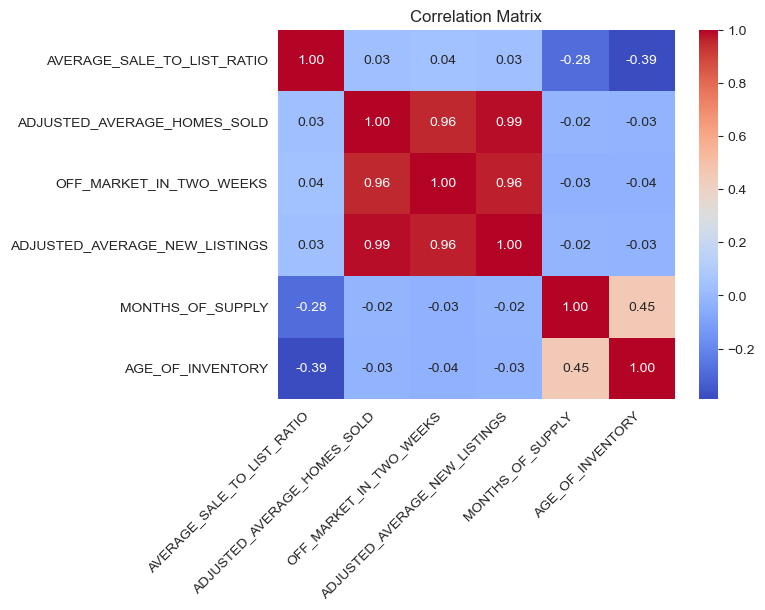

In [419]:
# <editor-fold desc="Click to see code"> 
corr = df[['AVERAGE_SALE_TO_LIST_RATIO', 'ADJUSTED_AVERAGE_HOMES_SOLD', 'OFF_MARKET_IN_TWO_WEEKS', 'ADJUSTED_AVERAGE_NEW_LISTINGS', 'MONTHS_OF_SUPPLY', 'AGE_OF_INVENTORY']].corr()
heatmap = sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title('Correlation Matrix')
plt.show()
plt.close()
# </editor-fold> 

Pairwise relationships between selected variables

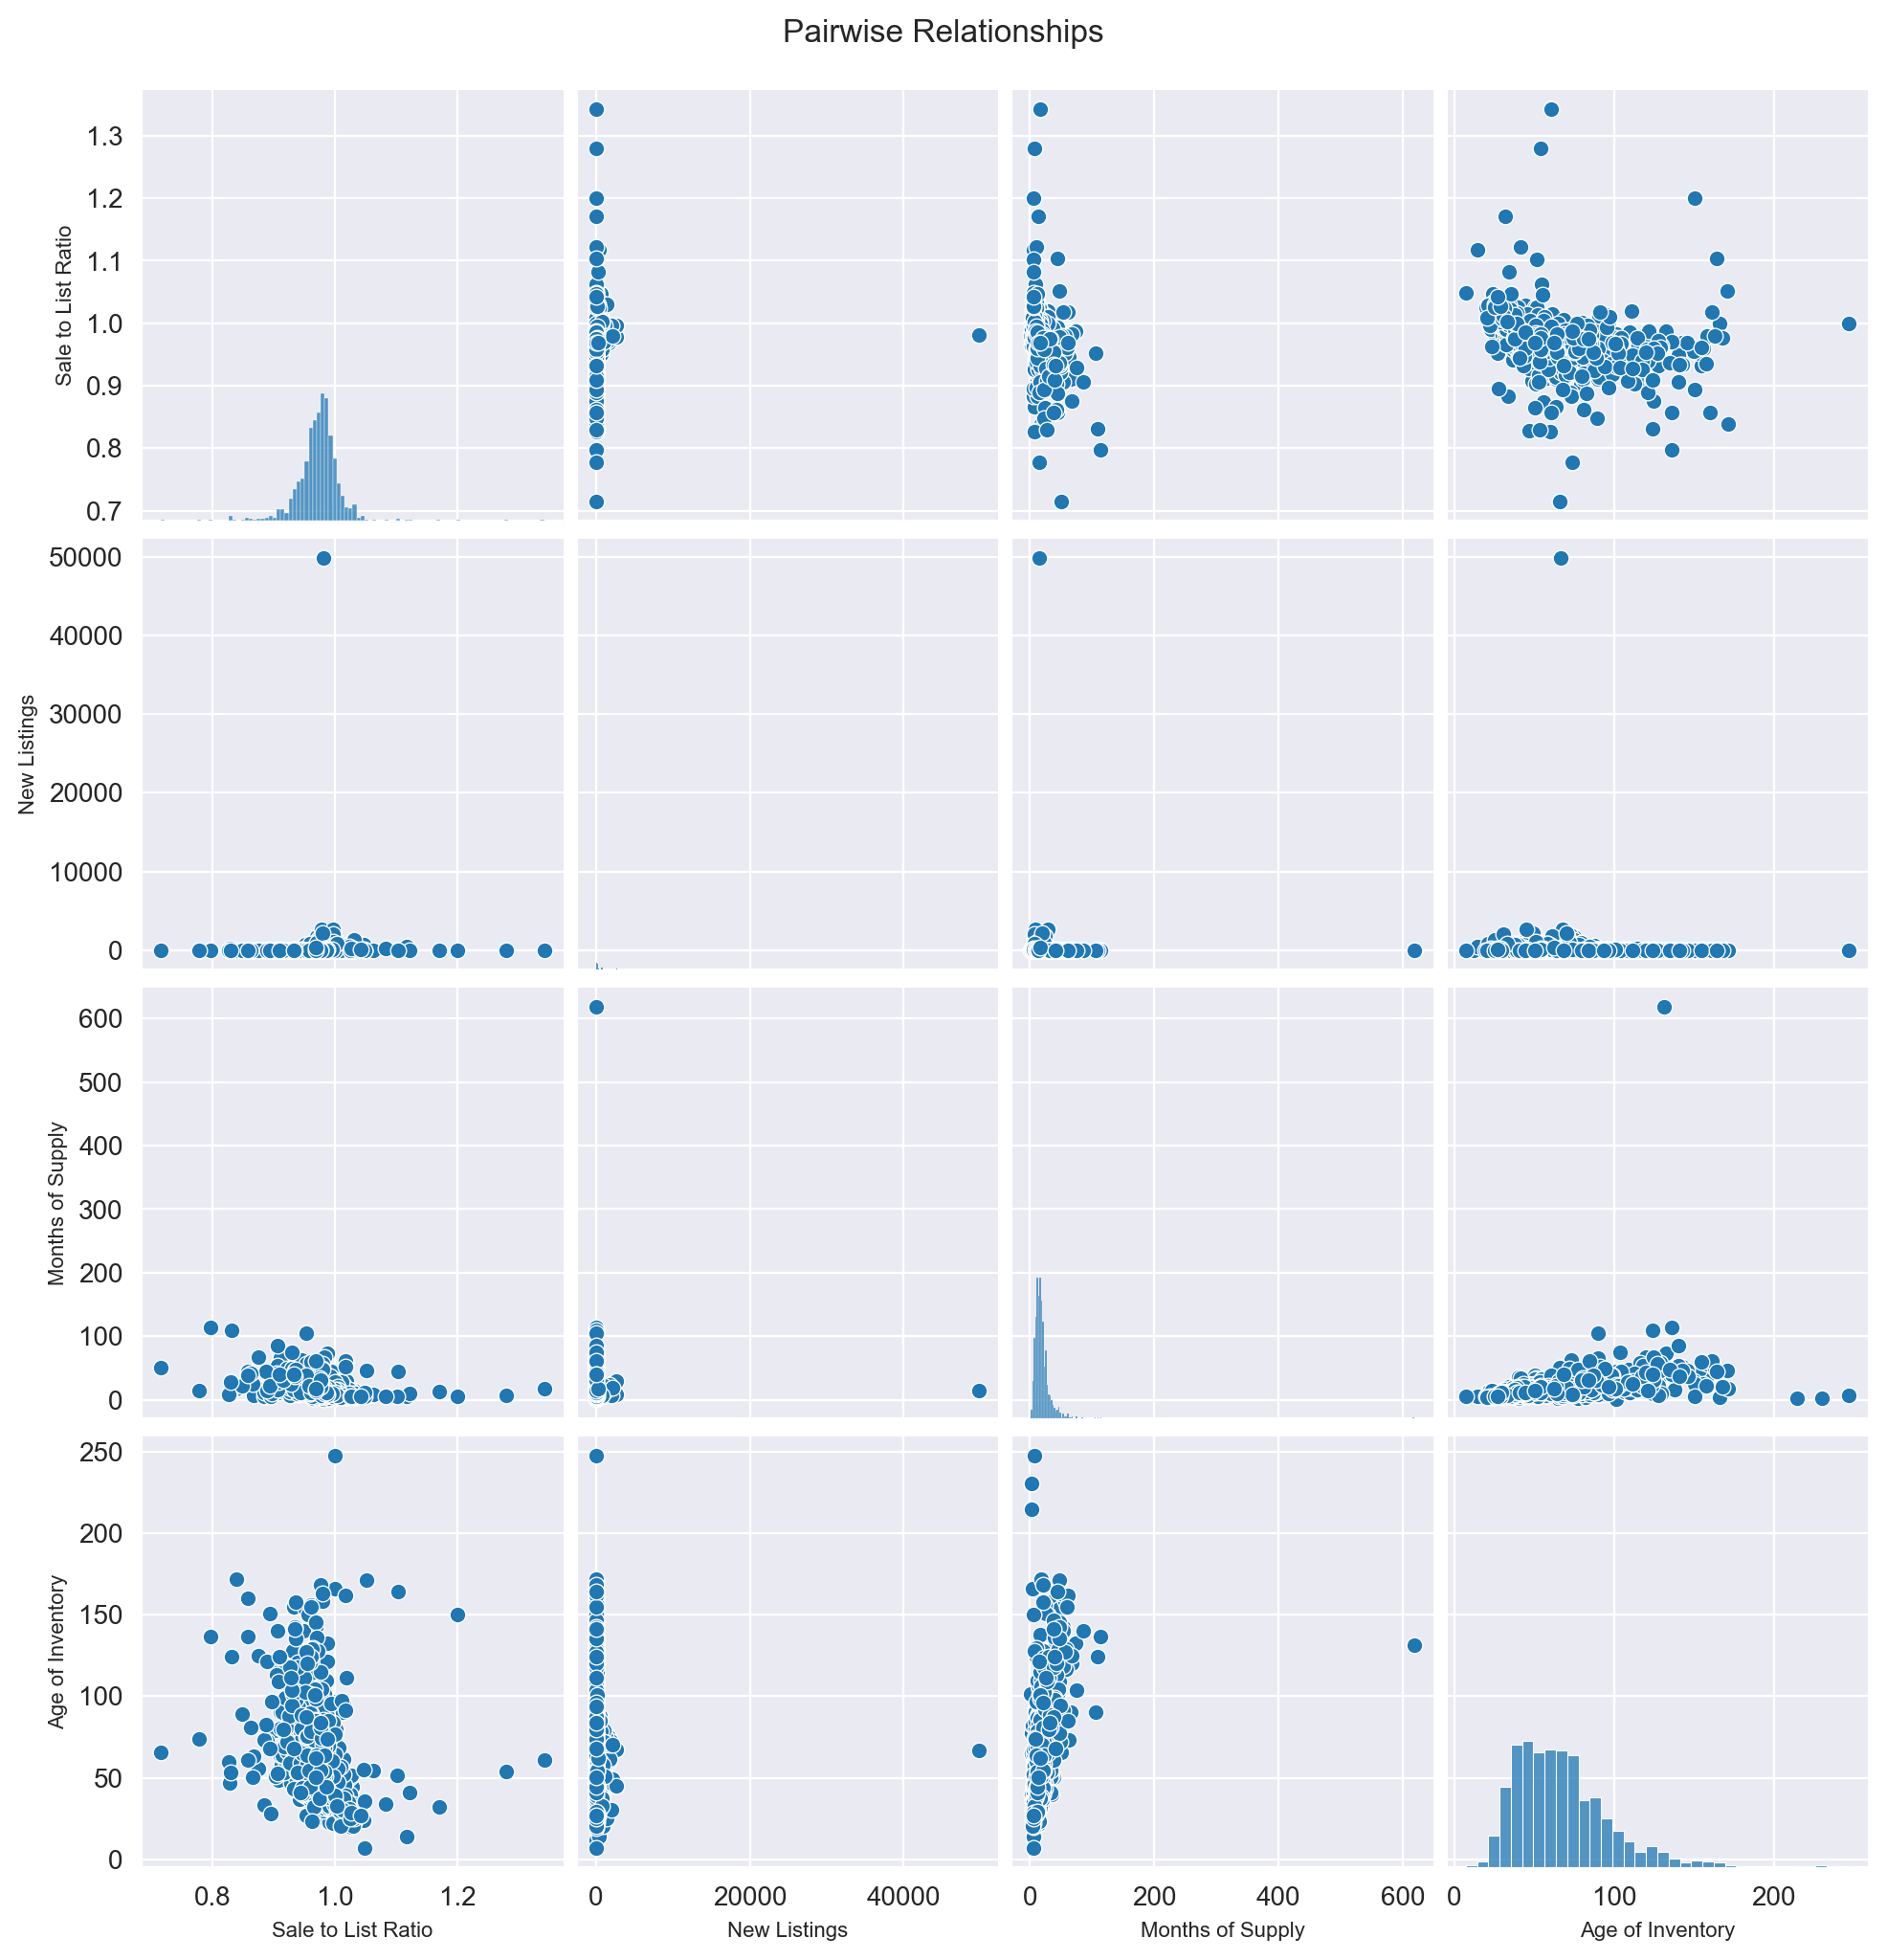

In [371]:
# <editor-fold desc="Click to see code">
df_sampled = df[['AVERAGE_SALE_TO_LIST_RATIO', 'ADJUSTED_AVERAGE_NEW_LISTINGS', 'MONTHS_OF_SUPPLY', 'AGE_OF_INVENTORY']].sample(1000)
df_sampled.rename(columns={
    'AVERAGE_SALE_TO_LIST_RATIO': 'Sale to List Ratio',
    'ADJUSTED_AVERAGE_NEW_LISTINGS': 'New Listings',
    'MONTHS_OF_SUPPLY': 'Months of Supply',
    'AGE_OF_INVENTORY': 'Age of Inventory'
}, inplace=True)
pairplot = sns.pairplot(df_sampled)
pairplot.fig.suptitle('Pairwise Relationships', y=1.02)
plt.rc('axes')
plt.show()
plt.close();
# </editor-fold>

Top 10 states with the highest median sale price.  
I guess I won't be moving to Hawaii anytime soon...

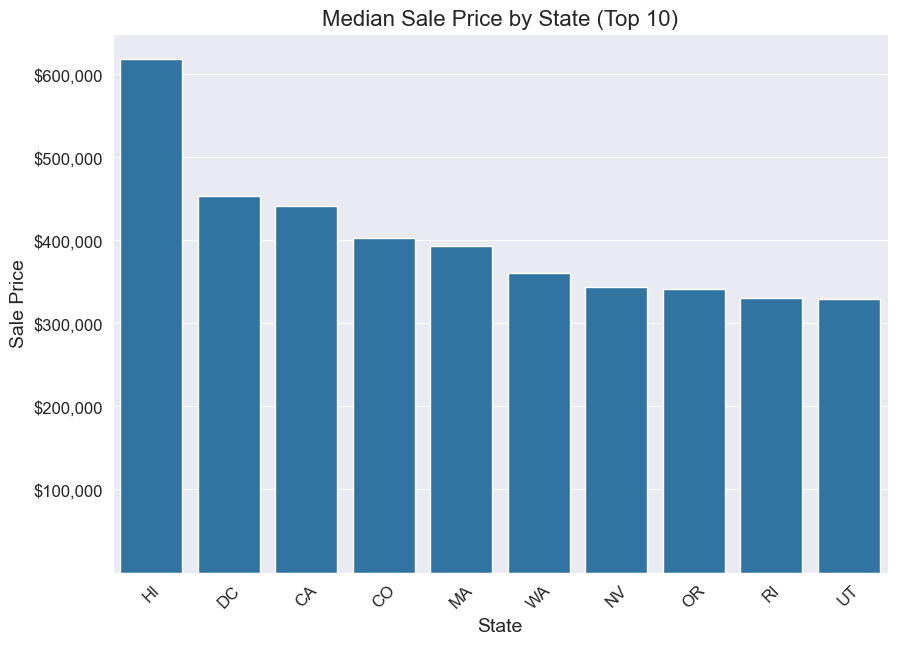

In [423]:
# <editor-fold desc="Click to see code">
# set figure size
plt.figure(figsize=(10, 7))
sales_by_state = df.groupby('STATE')['MEDIAN_SALE_PRICE'].median().sort_values(ascending=False).head(10).reset_index()
bar_plot = sns.barplot(x='STATE', y='MEDIAN_SALE_PRICE', data=sales_by_state)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Sale Price', fontsize=14)
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.FuncFormatter(lambda x, _: f'${x:,.0f}' if x != 0 else ''))
plt.xlabel('State', fontsize=14)
plt.title('Median Sale Price by State (Top 10)', fontsize=16)
plt.show()
plt.close()
# </editor-fold>

Grouping data by year and region to get a better understanding of yearly trends.

In [201]:
df2 = df[['PERIOD_BEGIN', 'REGION', 'MEDIAN_SALE_PRICE', 'MEDIAN_DAYS_ON_MARKET', 'MEDIAN_NEW_LISTING_PRICE', 'ADJUSTED_AVERAGE_HOMES_SOLD']].copy()
df2['YEAR'] = df2['PERIOD_BEGIN'].dt.year
df2 = df2.groupby(['YEAR', 'REGION']).agg({
    'MEDIAN_SALE_PRICE': 'median',
    'MEDIAN_DAYS_ON_MARKET': 'median',
    'MEDIAN_NEW_LISTING_PRICE': 'median',
    'ADJUSTED_AVERAGE_HOMES_SOLD': 'mean'
}).reset_index()

Dropping rows with missing values since the only 3 missing rows are from Alaska.

In [203]:
# show na values
df2.isna().sum()

YEAR                           0
REGION                         0
MEDIAN_SALE_PRICE              3
MEDIAN_DAYS_ON_MARKET          3
MEDIAN_NEW_LISTING_PRICE       0
ADJUSTED_AVERAGE_HOMES_SOLD    3
dtype: int64

In [204]:
# find na values
df2.loc[df2['MEDIAN_SALE_PRICE'].isna()]

,YEAR,REGION,MEDIAN_SALE_PRICE,MEDIAN_DAYS_ON_MARKET,MEDIAN_NEW_LISTING_PRICE,ADJUSTED_AVERAGE_HOMES_SOLD
2269,2019,"Juneau, AK metro area",NaN,NaN,775800.0000,NaN
3196,2020,"Juneau, AK metro area",NaN,NaN,775800.0000,NaN
5062,2022,"Ketchikan, AK metro area",NaN,NaN,199000.0000,NaN


In [205]:
df2.dropna(axis=0, inplace=True)

Line plot of year-over-year changes for larger metro areas.

In [304]:
df2.sort_values(by=['REGION', 'YEAR'], inplace=True)
cities = ['New York', 'Los Angeles', 'Chicago', 'Houston', 'Phoenix', 'Philadelphia']
pattern = '^' + '|^'.join(cities)
metro_area = df2[df2['REGION'].str.contains(pattern)]

In [305]:
metro_area['YOY_MEDIAN_SALE_PRICE'] = metro_area.sort_values(by='YEAR').groupby('REGION')['MEDIAN_SALE_PRICE'].pct_change()

metro_area.fillna(0, inplace=True)

Changes in Median Sale Price for the selected metro areas.

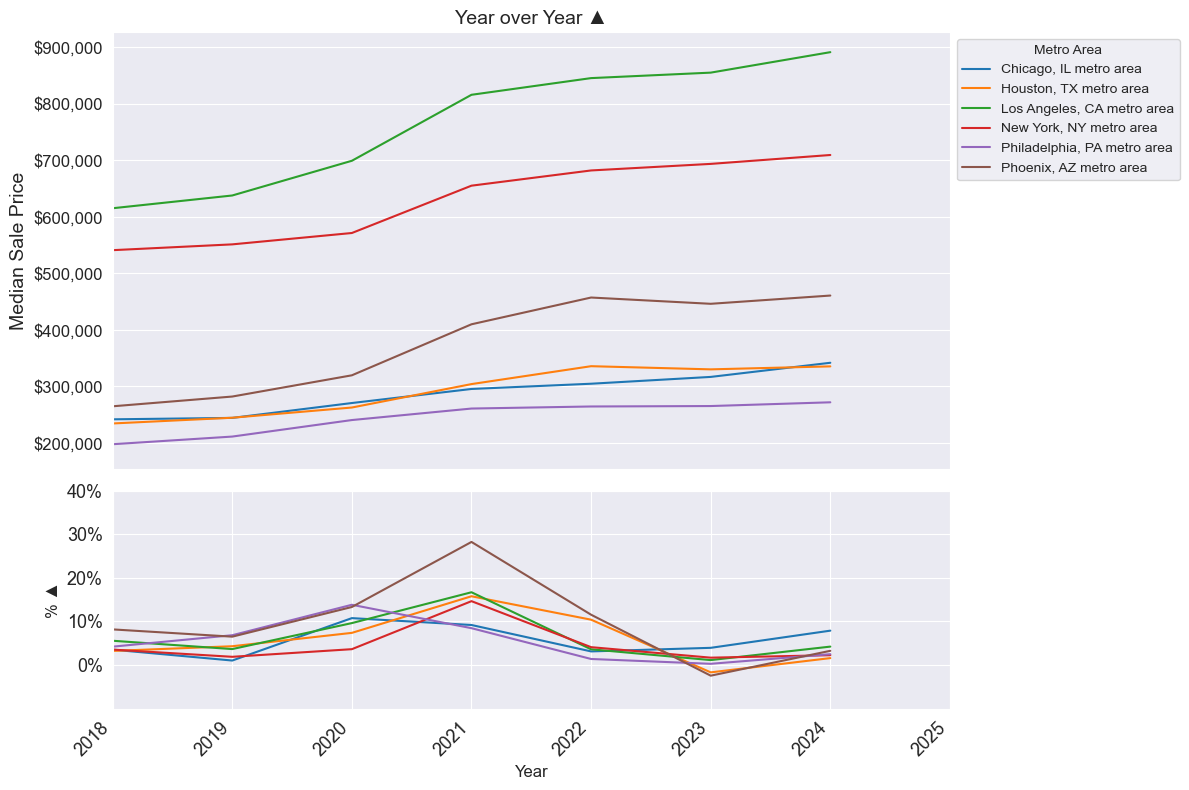

In [424]:
# <editor-fold desc="Click to see code">
fig1, (ax2, ax1) = plt.subplots(2, 1, figsize=(12, 8), sharex=True, gridspec_kw={'height_ratios': [4, 2]})

# first plot
legend = pd.crosstab(metro_area['REGION'], metro_area['YEAR'], values=metro_area['MEDIAN_SALE_PRICE'], aggfunc='mean').T.plot(ax=ax2)
ax2.legend(title='Metro Area', bbox_to_anchor=(1, 1))
ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '${:,.0f}'.format(y)))
# set font size y axis
ax2.yaxis.set_tick_params(labelsize=12)
ax2.set_xlim(2018, 2025)
ax2.xaxis.set_visible(False)
ax2.set_title('Year over Year \u25B2', fontsize=14)
ax2.set_ylabel('Median Sale Price', fontsize=14)
handles, labels = ax2.get_legend_handles_labels()

# second plot
pd.crosstab(metro_area['REGION'], metro_area['YEAR'], values=metro_area['YOY_MEDIAN_SALE_PRICE'], aggfunc='mean').T.plot(ax=ax1)
ax1.legend(handles=handles, labels=labels, title='Metro Area', bbox_to_anchor=(1, 1))
ax1.get_legend().remove()  # Remove the legend from the second plot
ax1.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax1.set_ylim(-0.1, 0.4)
ax1.set_xlim(2018, 2025)
ax1.title.set_visible(False)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_yticks([0, 0.1, 0.2, 0.3, 0.4])
ax1.set_ylabel('% \u25B2', fontsize=12)

# Adjust layout
plt.xticks(rotation=45, ha='right', fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
plt.show()
plt.close()
# </editor-fold>

We can see Phoenix has the highest increase in median sale price for 2021 at a whopping 30%! WIth a decrease in 2023.  

Los Angeles has the highest median sale price, followed by New York, no surprise there.

Here's the same plot using Plotly.

In [422]:
# <editor-fold desc="Click to see code">
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.io as pio

# Prepare data for plots
data1 = pd.crosstab(metro_area['REGION'], metro_area['YEAR'], values=metro_area['MEDIAN_SALE_PRICE'], aggfunc='mean').T.reset_index()
data2 = pd.crosstab(metro_area['REGION'], metro_area['YEAR'], values=metro_area['YOY_MEDIAN_SALE_PRICE'], aggfunc='mean').T.reset_index()

# Create a color palette and a mapping from region to color
color_palette = px.colors.qualitative.Plotly
regions = data1.columns[1:]
region_color_map = {region: color_palette[i % len(color_palette)] for i, region in enumerate(regions)}

# Create subplots
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.1)

# Add traces for both plots using the same colors
for region in regions:
    fig.add_trace(go.Scatter(x=data1['YEAR'], y=data1[region], mode='lines', name=region, line=dict(color=region_color_map[region])), row=1, col=1)
    fig.add_trace(go.Scatter(x=data2['YEAR'], y=data2[region], mode='lines', name=region, line=dict(color=region_color_map[region]), showlegend=False), row=2, col=1)

# Update y-axes and x-axis
fig.update_yaxes(title_text="Median Sale Price", tickformat='$,.0f', row=1, col=1)
fig.update_yaxes(title_text="% ▲", tickvals=[0, 0.1, 0.2, 0.3, 0.4], tickformat=".0%", row=2, col=1)
fig.update_xaxes(title_text="Year", row=2, col=1)

# Update layout
fig.update_layout(height=900, width=1200, title_text="Year over Year ▲", legend_title_text='Metro Area')

# Show the figure
fig.show()
# </editor-fold>